# Simulating dynamic models in Python

In general, many dynamic models encountered in engineering can be discretised into a system of differential algebraic equations (DAE) of the form:

\begin{equation}
\begin{aligned}
\frac{d \textbf{x}}{d t} & =\textbf{f}(\textbf{x}, \textbf{y}, t) \\
0 & =\textbf{g}(\textbf{y}, \textbf{x},  t)
\end{aligned}
\end{equation}

with the initial conditions $\textbf{x}(t_0) = x_0$ and $\textbf{y}(t_0) = y_0$. In general this system can be simulated with a `for` or `while` loop with the following three steps each loop:

1. Solve the system of algebraic equations $0 =g(\textbf{y}, \textbf{x}, t)$ for $\textbf{y}$ at the current timestep $t$ using $\textbf{x}=\textbf{x}(t)$.
1. Compute $\textbf{f}(\textbf{x}, \textbf{y}, t)$.
1. Add the solution $\textbf{f}$ to an _integrator_ (e.g. Euler, Runge-Kutta family of methods etc.) to advance the system for a timestep $\Delta t$.

When the timestep $\Delta t$ is small enough many dynamic simulations without singularities will converge using simple numerical methods. 

The code block below is a template of the simplest python loop using a forward Euler method: 
```python
t_f = 10  # Simulate for 10 seconds of time
dt = 0.1  # The timestep in seconds
t = 0  # Set initial time equal to 0 s
x = [1.5, 2, ..., 1]  # Set the initial x vector equal to x_0
y = [1, 0.5, ..., 0]  # Set the initial y vector equal to y_0
x_sol = []  # List of solutions at each time step
y_sol = []  # Usually this is not needed as it can be reconstructed from x, t
t_sol = []  # List of time steps at each solution

# Start main while/for loop:
while t < t_f:
    # 1. (solver) Solve algebraic equations 0 = g(y, x, t) 
    # using analytical solutions, iterative methods or a solver 
    # such as scipy.optimize.fsolve
    y = ...  # New solution vector
    # 2. Compute f(x, y, t):
    f = ...  # solve the system with current x, y, t
    dxdt = f  # 
    # 3. (integrator) Advance the time of the (Eulerian step):
    x = x + dxdt * dt  # Advance the system using forward Euler step of the simulation
    t += dt  # Advance the time
    # Save the solutions:
    x_sol.append(x), y_sol.append(y), t_sol.append(t)
```

In steady-state systems the independent variable $t$ is often replaced with another variable such as reactor volume $V$.



In [1]:
# Basic imports 
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

## Example tank flow system

We will use the following example from [AP Monitor](http://apmonitor.com/che263/index.php/Main/PythonDynamicSim) in order to demonstrate the three steps outlined above:

Example 1: A system of two tanks have the following differential equations that relates the inlet flow to the height of the tanks:
$$
A_c \frac{d h_1}{d t}=q_{\text {in }}-q_{\text {out } 1} \quad A_c \frac{d h_2}{d t}=q_{\text {out } 1}-q_{\text {out } 2}
$$
The system has two algebraic equations for the height dependent outlet flow rate according to Bernoulli's equation for each tank:

$$q_{\text {out } 1}=c_1 \sqrt{h_1} \quad q_{\text {out2 }}=c_2 \sqrt{h_2}$$

Both tanks are initially empty when the inlet to the first starts to flow at a rate of $0.5 \mathrm{~m}^3 / \mathrm{h}$.

<img src="ant_ii_ex_.svg"  width="240">

###  Restate the problem in standard format


First we start with the algebraic equations:

\begin{equation}
\begin{aligned}
q_{\text {out } 1}=c_1 \sqrt{h_1} \\
q_{\text {out2 }}=c_2 \sqrt{h_2}
\end{aligned}
\end{equation}

We need to put this into the format

\begin{equation}
\begin{aligned}
0 & =\textbf{g}(\textbf{y}, \textbf{x}, t)
\end{aligned}
\end{equation}

First we replace the notation for the differential variables which are $x_1 = h_1$ and $x_2 = h_2$ and the algebriac variables  $y_1 = q_{\text {out } 1}$ and $y_2 = q_{\text {out } 2}$:

\begin{equation}
\begin{aligned}
y_1=c_1 \sqrt{x_1} \\
y_2=c_2 \sqrt{x_2}
\end{aligned}
\end{equation}

Note that standard solvers usually need the algebraic equations to zero:

\begin{equation}
\begin{aligned}
0 = c_1 \sqrt{x_1} - y_1 \\
0 = c_2 \sqrt{x_2} - y_2
\end{aligned}
\end{equation}






Next, we transform the differential equations into our notation:

\begin{equation}
\begin{aligned}
A_c \frac{d h_1}{d t}=q_{\text {in }}-q_{\text {out } 1} \\
 A_c \frac{d h_2}{d t}=q_{\text {out } 1}-q_{\text {out } 2}
\end{aligned}
\end{equation}

becomes:

\begin{equation}
\begin{aligned}
 \frac{d x_1}{d t}=\frac{q_{\text {in }}-y_1}{A_c} \\
 \frac{d x_2}{d t}=\frac{y_1 - y_2}{A_c}
\end{aligned}
\end{equation}

Where $q_{\text {in} }$ is called an input to the system and $A_c$, $c_1$ and $c_2$ are constant parameters. The overall system is then 



\begin{equation}
\begin{aligned}
 \frac{d x_1}{d t} & = f_1(\textbf{x}, \textbf{y}, t) = \frac{q_{\text {in }}-y_1}{A_c} \\
 \frac{d x_2}{d t} & = f_1(\textbf{x}, \textbf{y}, t) = \frac{y_1 - y_2}{A_c} \\
0 & = g_1(\textbf{x}, \textbf{y}, t) = c_1 \sqrt{x_1} - y_1 \\
0 & = g_2(\textbf{x}, \textbf{y}, t) = c_2 \sqrt{x_2} - y_2
\end{aligned}
\end{equation}

with initial conditions:
$$ x_1 (t=0) = x_2(t=0) = y_1(t=0) = y_2(t=0) = 0$$

In our example we will make the tank inflow time depedent so that 

$$
q_{in} = 
     \begin{cases}
       &   0.5  &, t \leq 4 \\
                 &  0  &, t > 4
     \end{cases}
$$

In code this is simply:

In [2]:
def q_in(t):  # Flow rate into first tank m^3 /h
    if t <= 4:
        return 0.5  # m^3/h
    elif t > 4:
        return 0.0  # m^3/h
        

## 1. Solving algrebraic equations

While the equations in this problem statement have exact analytical solutions, we will show how to solve any general system of equations when it is written in standard form $0  =\textbf{g}(\textbf{y}, \textbf{x},  t)$ using a numerical equation solver like [scipy.optimize.fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html):




In [3]:
# Define the parameters 
Ac = 2  # m^2, cross sectional area of the tanks
c1 = 0.13  # -, valve constant 1
c2 = 0.20  # -, valve constant 2

# Define a function that returns the system of algebraic equations:
def g_sys(y, x, t):
    # Return the vector [g1, ..., gn]
    g1 = c1 * np.sqrt(x[0]) - y[0]  # = c_1 sqrt(x_1) - y_1
    g2 = c2 * np.sqrt(x[1]) - y[1]  # = c_2 sqrt(x_2) - y_2
    return [g1, g2]

# Test the solver for the initial conditions:
x0 = [0, 0]  # [x_1 (t_0), x_2 (t_0)]
y0 = [0, 0]  # [y_1 (t_0), y_2 (t_0)]
t0 = 0  # h, starting time

scipy.optimize.fsolve(g_sys, y0, args=(x0, t0))  # Solves g_sys, outputs solution y
# It is also worth testing g_sys(x0, y0, t0) while writing g_sys

array([0., 0.])

Next we wrap the entire solution method into a function that computes the solution to simplify the later loop:

In [4]:
def g_sol(y, x, t):
    # Note: Instead of returning the numerical solution,
    #       the analytical can also be set here.
    sol = scipy.optimize.fsolve(g_sys, y, args=(x, t))  # = [y1, y2]
    return sol

y = g_sol(y0, x0, t0)
y

array([0., 0.])

## 2. Compute $\frac{d \textbf{x}}{d t}  =\textbf{f}(\textbf{x}, \textbf{y}, t) $

The next step is to write a function that returns the right-hand side of the system $\frac{d \textbf{x}}{d t}  =\textbf{f}(\textbf{x}, \textbf{y}, t) $. This can then be used 

In [5]:
def f_sys(x, y, t):
    f1 = (q_in(t) - y[0]) / Ac
    f2 = (y[0] - y[1]) / Ac
    f = np.array([f1, f2])  # Wrap into array data type (vector)
    return f  # Return vector of solutions f

# Test for initial conditions (including y computed in the previous cell):
dxdt = f_sys(y, x0, t0)
dxdt

array([0.25, 0.  ])

This is a good time to perform some basic sanity checks when possible to see if the system makes physical sense. For this example we expect the height of the first tank to increase while the flow out of the second tank should be zero (since the initial height of tank 1 is zero and there can be no flow out) as the output shows.  

## 3. Integrator

Finally we add the functions to our integrator. First we will use a simple forward step Euler method `while` loop:

In [6]:
# Define the parameters 
Ac = 2  # m^2, cross sectional area of the tanks
c1 = 0.13  # -, valve constant 1
c2 = 0.20  # -, valve constant 2

# Define the numerical simulation parameters
t = 0  # Set initial time equal to 0 h
t_f = 10  # Simulate for 10 hours of time
dt = 0.1  # The timestep in hours

# Set the initial conditions
x = [0, 0]  # Set the initial x vector equal to [x_1(t=0), x_2(t=0)]
y = [0, 0]  # Set the initial y vector equal to [y_1(t=0), y_2(t=0)]

# Define data containers to save each time step
x_sol = []  # List of solutions at each time step
y_sol = []  # Usually this is not needed as it can be reconstructed from x, t
t_sol = []  # List of time steps at each solution

# Start main for loop:
while t < t_f:
    # 1. (solver) Solve algebraic equations 0 = g(y, x, t) 
    # using analytical solutions, iterative methods or a solver 
    # such as scipy.optimize.fsolve
    y = g_sol(y, x, t)  # New solution vector
    # 2. Compute f(x, y, t):
    dxdt = f_sys(x, y, t)  # solve the system dxdt = f(x, y, t) with current x, y, t
    # 3. (integrator) Advance the time of the (Eulerian step):
    x = x + dxdt * dt  # Advance the system using forward Euler step of the simulation
    t += dt  # Advance the time
    # Save the solutions:
    x_sol.append(x), y_sol.append(y), t_sol.append(t)

In [7]:
# Process data
x_sol = np.array(x_sol)  # Put list into an array for easier processing
y_sol = np.array(y_sol)  # "
x_sol[:, 0]#, y_sol 

array([0.025     , 0.04897226, 0.07253383, 0.09578324, 0.11877157,
       0.14153146, 0.16408611, 0.18645312, 0.20864641, 0.23067735,
       0.25255547, 0.2742889 , 0.29588468, 0.31734899, 0.3386873 ,
       0.3599045 , 0.38100502, 0.40199286, 0.42287167, 0.44364481,
       0.46431538, 0.48488623, 0.50536004, 0.52573927, 0.54602626,
       0.56622318, 0.58633207, 0.60635487, 0.6262934 , 0.64614938,
       0.66592446, 0.68562019, 0.70523804, 0.72477945, 0.74424574,
       0.76363821, 0.78295809, 0.80220657, 0.82138478, 0.84049381,
       0.83453472, 0.82859678, 0.82268   , 0.81678439, 0.81090995,
       0.80505666, 0.79922454, 0.79341358, 0.78762379, 0.78185515,
       0.77610769, 0.77038138, 0.76467624, 0.75899227, 0.75332946,
       0.74768781, 0.74206733, 0.73646802, 0.73088986, 0.72533288,
       0.71979706, 0.7142824 , 0.70878891, 0.70331659, 0.69786543,
       0.69243544, 0.68702661, 0.68163895, 0.67627246, 0.67092713,
       0.66560297, 0.66029998, 0.65501816, 0.6497575 , 0.64451

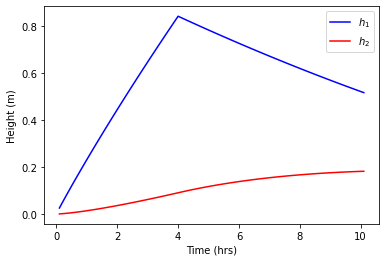

In [8]:
plt.figure()
plt.plot(t_sol, x_sol[:, 0],'b-', label='$h_1$')
plt.plot(t_sol, x_sol[:, 1],'r-', label='$h_2$')
plt.xlabel('Time (hrs)')
plt.ylabel('Height (m)')
plt.legend()
plt.show()

#### Using advanced integrators

Most DAE systems you will encounter in Chemical Engineering have numerical challenges such as stiffness (especially common in reactive systems). It is recommended that you use more advanced scientific and numerical libraries to solve these problems. The development so far in this notebook has intentionally been working towards a common standard used by the `scipy` library among others. The `LSODA` method of `scipy.integrate.solve_ivp` can automatically detect stiffness while the solver is progressing which is particularly suited to the highly stiff coagulation systems that we deal with in this course:

In [12]:
import scipy.integrate

tspan = (t0, t_f) # Timespan of start and end time, h

# Wrap the DAE system for scipy.integrate.solve_ivp solver
def dxdt(t, x, y):
    # 1. Solve algebraic equations
    y = g_sol(y, x, t)  # New solution vector
    # 2. Compute f(x, y, t):
    dxdt = f_sys(x, y, t)  # solve the system dxdt = f(x, y, t) with current x, y, t
    return dxdt

# Simulate the system:
res = scipy.integrate.solve_ivp(dxdt, tspan, x0, method='LSODA', args=(y0,))
res

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 117
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.26491096e-04, 2.52982193e-04, 1.31490008e-03,
       2.37681798e-03, 5.16432362e-03, 7.95182926e-03, 1.07393349e-02,
       1.93900111e-02, 2.80406873e-02, 3.66913635e-02, 5.36606826e-02,
       7.06300017e-02, 8.75993207e-02, 1.16958979e-01, 1.46318638e-01,
       1.75678296e-01, 2.27160717e-01, 2.78643137e-01, 3.30125558e-01,
       3.81607978e-01, 5.06043388e-01, 6.30478797e-01, 7.54914207e-01,
       8.79349616e-01, 1.14792890e+00, 1.41650819e+00, 1.68508747e+00,
       1.95366675e+00, 2.54202871e+00, 3.13039066e+00, 3.71875262e+00,
       3.83642501e+00, 3.95409740e+00, 3.98706964e+00, 3.99944732e+00,
       4.00096607e+00, 4.00248483e+00, 4.00552234e+00, 4.00855985e+00,
       4.03893495e+00, 4.06931005e+00, 4.09968516e+00, 4.40343618e+00,
       4.70718720e+00, 5.01093822e+00, 5

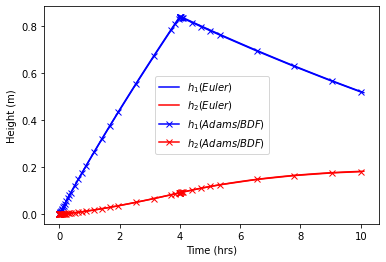

In [11]:
plt.figure()
plt.plot(t_sol, x_sol[:, 0],'b-', label='$h_1 (Euler) $')
plt.plot(t_sol, x_sol[:, 1],'r-', label='$h_2 (Euler) $')
plt.plot(res.t, res.y[0, :],'b-x', label='$h_1 (Adams/BDF) $')
plt.plot(res.t, res.y[1, :],'r-x', label='$h_2 (Adams/BDF) $')
plt.xlabel('Time (hrs)')
plt.ylabel('Height (m)')
plt.legend()
plt.show()

# Discretising partial differential equations

The next step is to understand how to turn the partial differential equation (PDE) from our coagulation model into a DAE system that we can simulate. This will in turn also allow us to understand the discretisation of the coagulation model term $\frac{\partial n\left(v_p, t\right)}{\partial t}$ into a system of differential equations $\frac{\mathrm{d} N_i}{\mathrm{~d} t}$ where $N_i$ corresponds to a bin interval of particle volumes $v_p$. The notebook `Coagulation 1` demonstrates this process.